In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:, np.newaxis]


def display_samples(ax, x, color):
    """Displays samples on the unit interval using a density curve."""
    kde = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(x.data.cpu().numpy())
    dens = np.exp(kde.score_samples(t_plot))
    dens[0] = 0
    dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

In [3]:
N, M = (50, 50) if not use_cuda else (10000, 10000)

t_i = torch.linspace(0, 1, N).type(dtype).view(-1, 1)
t_j = torch.linspace(0, 1, M).type(dtype).view(-1, 1)

X_i, Y_j = 0.2 * t_i, 0.4 * t_j + 0.6

In [4]:
def gradient_flow(loss, lr=0.01):
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .025):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = int(5 / lr) + 1
    display_its = [int(t / lr) for t in [0, 0.25, 0.50, 1.0, 2.0, 5.0]]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 8))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 3, k)
            k = k + 1

            display_samples(ax, y_j, (0.55, 0.55, 0.95))
            display_samples(ax, x_i, (0.95, 0.55, 0.55))

            ax.set_title("t = {:1.2f}".format(lr * i))
            plt.axis([-0.1, 1.1, -0.1, 5.5])
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "t = {:1.2f}, elapsed time: {:.2f}s/it".format(
            lr * i, (time.time() - t_0) / Nsteps
        )
    )


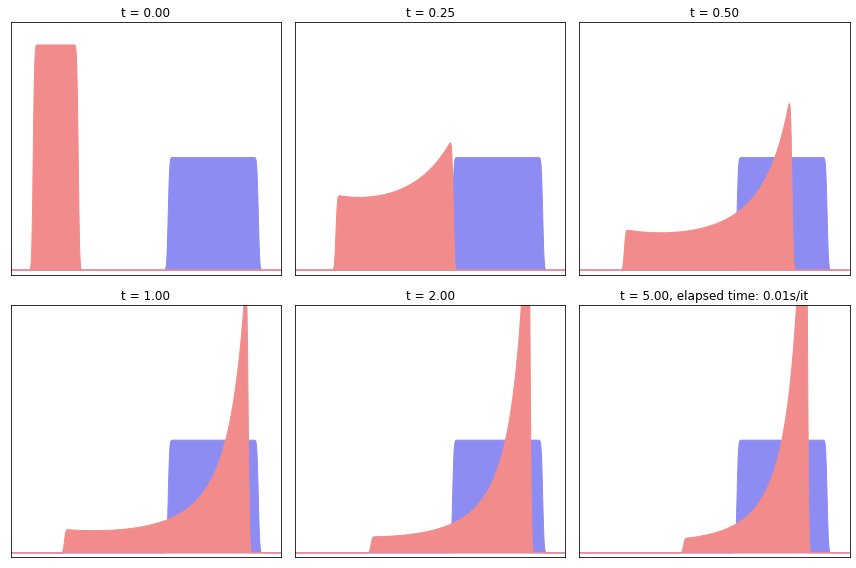

In [5]:
gradient_flow(SamplesLoss("gaussian", blur=0.5))

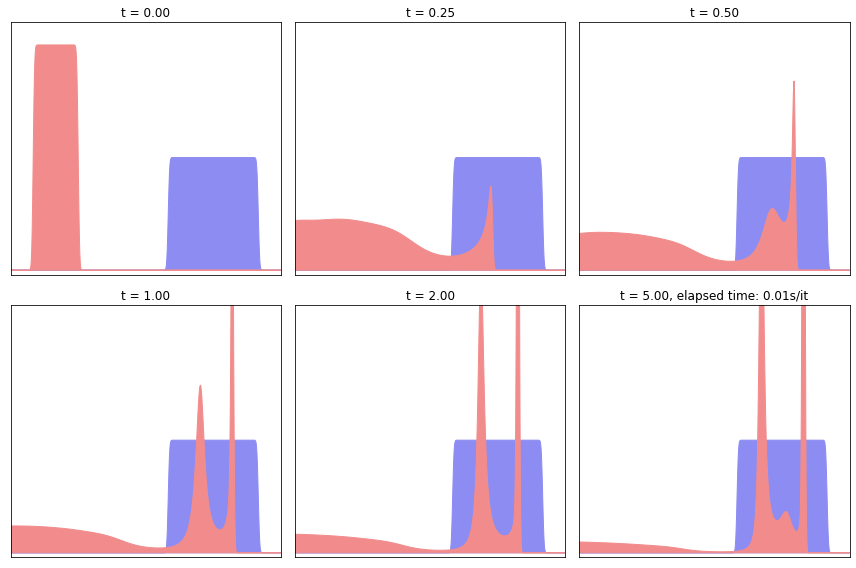

In [6]:
gradient_flow(SamplesLoss("gaussian", blur=0.1))

In [7]:


t_plot = np.linspace(-0.5, 1.5, 1000)[:, np.newaxis]


def display_samples(ax, x, color, label=None):
    """Displays samples on the unit interval using a density curve."""
    kde = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(x.data.cpu().numpy())
    dens = np.exp(kde.score_samples(t_plot))
    dens[0] = 0
    dens[-1] = 0
    ax.fill(t_plot, dens, color=color, label=label)



[pyKeOps] Compiling libKeOpstorchd4c6e450c6 in /home/cody/.cache/pykeops-1.5-cpython-38:
       formula: Max_SumShiftExp_Reduction(( B - (P * (SqDist(X,Y) / IntCst(2)) ) ),0)
       aliases: X = Vi(0,1); Y = Vj(1,1); B = Vj(2,1); P = Pm(3,1); 
       dtype  : float32
... 
Done.


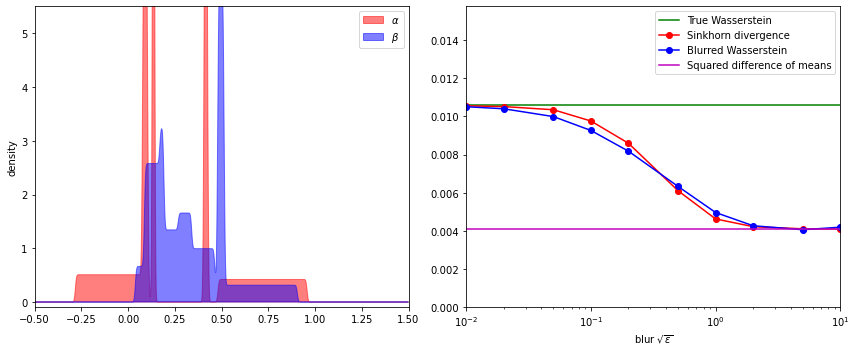

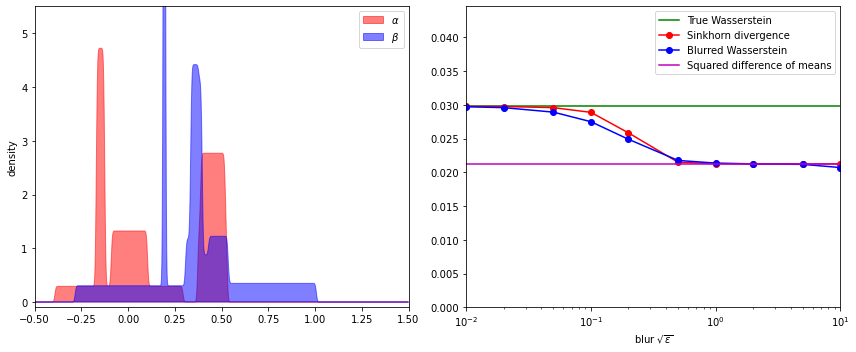

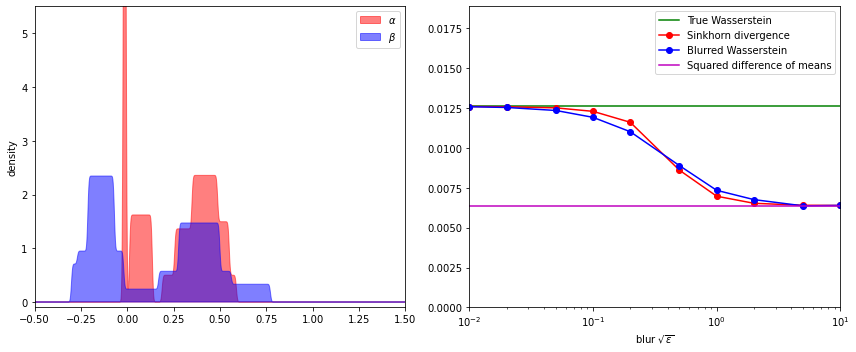

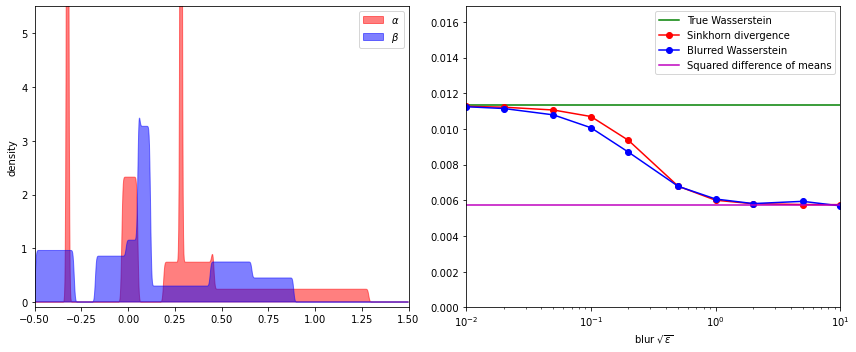

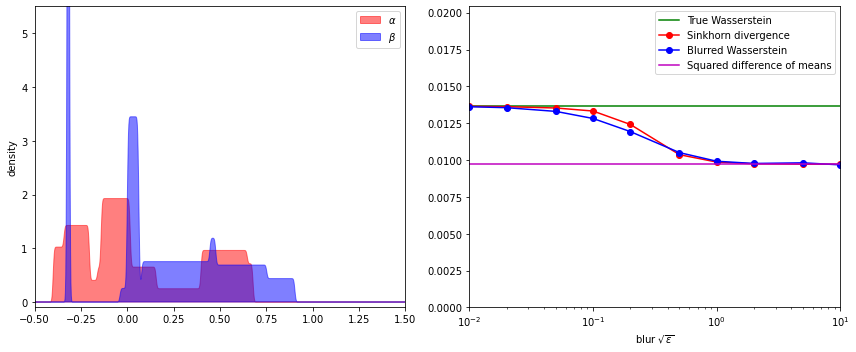

In [8]:
def rweight():
    """Random weight."""
    return torch.rand(1).type(dtype)


N = 100 if not use_cuda else 10 ** 3  # Number of samples per measure
C = 100 if not use_cuda else 10000  # number of copies for the Gaussian blur

for _ in range(5):  # Repeat the experiment 5 times
    K = 5  # Generate random 1D measures as the superposition of K=5 intervals
    t = torch.linspace(0, 1, N // K).type(dtype).view(-1, 1)
    X_i = torch.cat([rweight() ** 2 * t + rweight() - 0.5 for k in range(K)], dim=0)
    Y_j = torch.cat([rweight() ** 2 * t + rweight() - 0.5 for k in range(K)], dim=0)

    # Compute the limits when blur = 0...
    x_, _ = X_i.sort(dim=0)
    y_, _ = Y_j.sort(dim=0)
    true_wass = (0.5 / len(X_i)) * ((x_ - y_) ** 2).sum()
    # and when blur = +infinity:
    mean_diff = 0.5 * ((X_i.mean(0) - Y_j.mean(0)) ** 2).sum()

    blurs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
    sink, bwass = [], []

    for blur in blurs:
        # Compute the Sinkhorn divergence:
        # N.B.: To be super-precise, we use the well-tested "online" backend
        #       with a very large 'scaling' coefficient
        loss = SamplesLoss("sinkhorn", p=2, blur=blur, scaling=0.99, backend="online")
        sink.append(loss(X_i, Y_j).item())

        # Compute the blurred Wasserstein distance:
        x_i = torch.cat([X_i] * C, dim=0)
        y_j = torch.cat([Y_j] * C, dim=0)
        x_i = x_i + 0.5 * blur * torch.randn(x_i.shape).type(dtype)
        y_j = y_j + 0.5 * blur * torch.randn(y_j.shape).type(dtype)
        x_, _ = x_i.sort(dim=0)
        y_, _ = y_j.sort(dim=0)

        wass = (0.5 / len(x_i)) * ((x_ - y_) ** 2).sum()
        bwass.append(wass.item())

    # Fancy display:
    plt.figure(figsize=(12, 5))

    if N < 10 ** 5:
        ax = plt.subplot(1, 2, 1)
        display_samples(ax, X_i, (1.0, 0, 0, 0.5), label="$\\alpha$")
        display_samples(ax, Y_j, (0, 0, 1.0, 0.5), label="$\\beta$")
        plt.axis([-0.5, 1.5, -0.1, 5.5])
        plt.ylabel("density")
        ax.legend()
        plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    plt.plot([0.01, 10], [true_wass, true_wass], "g", label="True Wasserstein")
    plt.plot(blurs, sink, "r-o", label="Sinkhorn divergence")
    plt.plot(blurs, bwass, "b-o", label="Blurred Wasserstein")
    plt.plot(
        [0.01, 10], [mean_diff, mean_diff], "m", label="Squared difference of means"
    )
    ax.set_xscale("log")
    ax.legend()
    plt.axis([0.01, 10.0, 0.0, 1.5 * bwass[0]])
    plt.xlabel("blur $\\sqrt{\\varepsilon}$")
    plt.tight_layout()
    plt.show()